## Brief description of the problem and data (5 pts)

Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 

A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

Your task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, ReLU, BatchNormalization, Input, Add, Concatenate, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models

import glob
from tqdm import tqdm
from PIL import Image
import random
import warnings
warnings.filterwarnings('ignore', message='not allowed')

In [ ]:

monet_jpg_path = 'monet_jpg'
photo_jpg_path = 'photo_jpg'
generated_images_path = 'generated_monet_images'
os.makedirs(generated_images_path, exist_ok=True)

## Data Description


- The Monet paintings (monet_jpg) are used as the target style for the GAN.
- The photographs (photo_jpg) are used as the source images that will be transformed into the Monet style.
- The goal is to train the GAN model to learn the artistic style of Monet and apply it to the photographs, generating new images that resemble Monet's paintings.

In [ ]:

monet_images = os.listdir(monet_jpg_path)
random_image = random.choice(monet_images)
random_image_path = os.path.join(monet_jpg_path, random_image)

In [ ]:

with Image.open(random_image_path) as img:
    image_format = img.format
    image_size = img.size 
    image_mode = img.mode


In [ ]:
print(f"Randomly selected image: {random_image}")
print(f"Format: {image_format}")
print(f"Dimensions (Width x Height): {image_size}")
print(f"Mode: {image_mode}")

Randomly selected image: 058f878b7c.jpg
Format: JPEG
Dimensions (Width x Height): (256, 256)
Mode: RGB


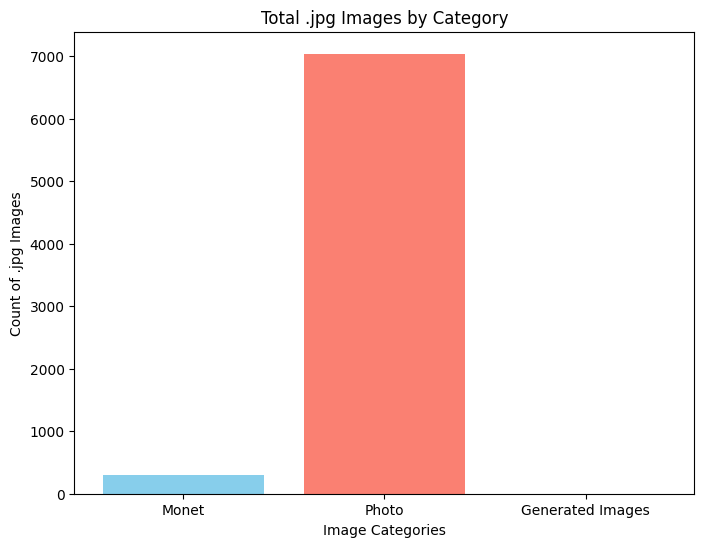

In [ ]:

def count_jpg_images(directory):
    return len([file for file in os.listdir(directory) if file.lower().endswith('.jpg')])


monet_jpg_count = count_jpg_images(monet_jpg_path)
photo_jpg_count = count_jpg_images(photo_jpg_path)
generated_images_count = count_jpg_images(generated_images_path)

counts = [monet_jpg_count, photo_jpg_count, generated_images_count]

labels = ['Monet', 'Photo', 'Generated Images']

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['skyblue', 'salmon', 'lightgreen'])
plt.xlabel('Image Categories')
plt.ylabel('Count of .jpg Images')
plt.title('Total .jpg Images by Category')
plt.show()

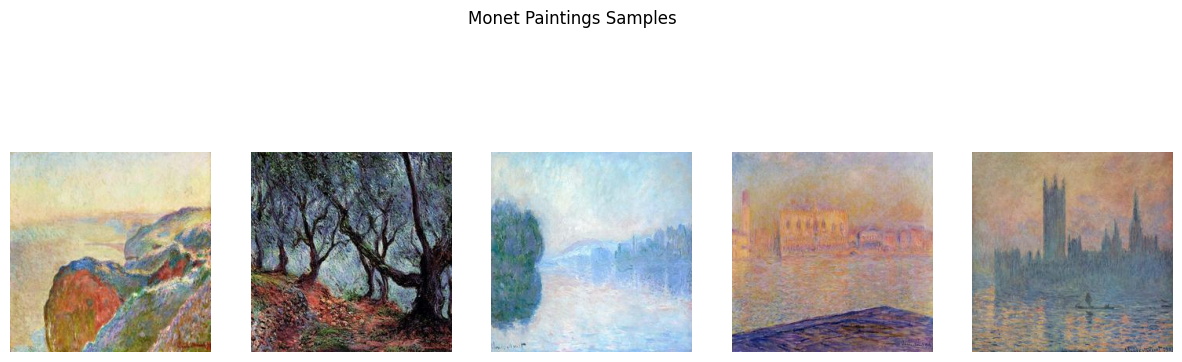

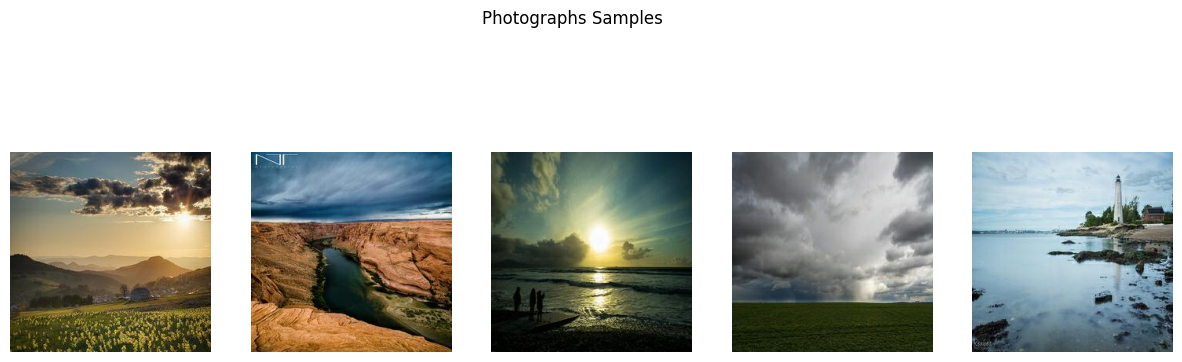

In [ ]:

def load_images_from_directory(directory, num_samples=5):
    images = []
    filenames = [f for f in os.listdir(directory) if f.endswith('.jpg')][:num_samples]
    for filename in filenames:
        img_path = os.path.join(directory, filename)
        image = Image.open(img_path)
        images.append(np.array(image))
    return images
monet_samples = load_images_from_directory(monet_jpg_path)
photo_samples = load_images_from_directory(photo_jpg_path)
def display_samples(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    fig.suptitle(title)
    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()
display_samples(monet_samples, "Monet Paintings Samples")
display_samples(photo_samples, "Photographs Samples")

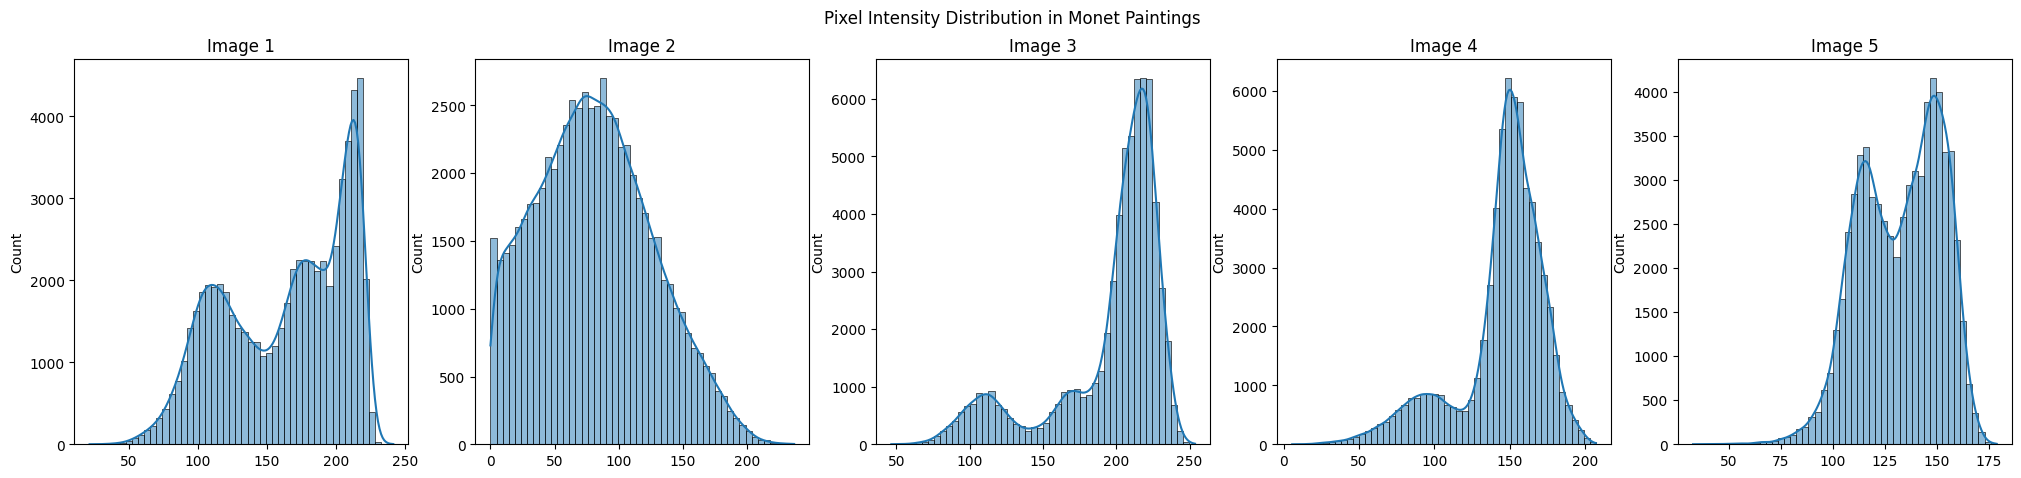

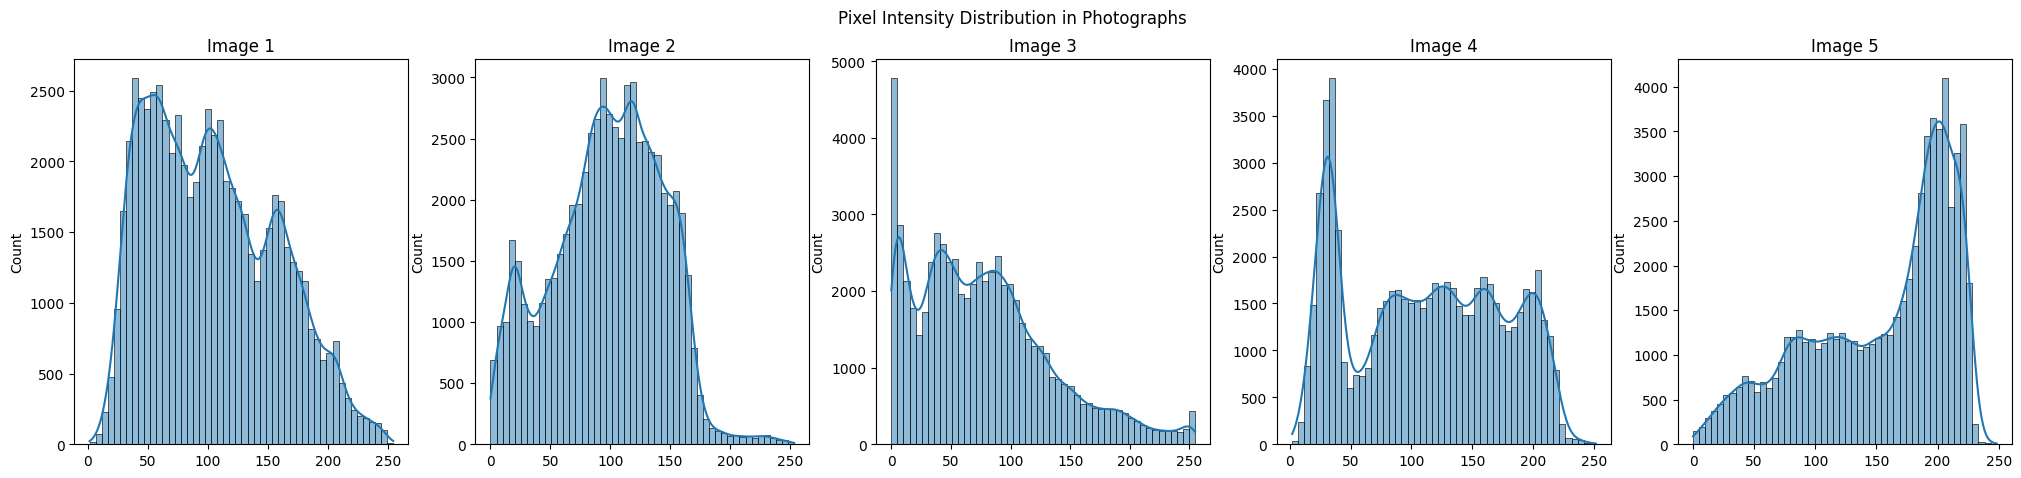

In [ ]:

def plot_pixel_intensity_histograms(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(25, 5))
    fig.suptitle(title)
    for i, img in enumerate(images):
        if len(img.shape) == 3:
            img = img.mean(axis=2)
        sns.histplot(img.flatten(), bins=50, ax=axes[i], kde=True)
        axes[i].set_title(f'Image {i+1}')
    plt.show()
plot_pixel_intensity_histograms(monet_samples, "Pixel Intensity Distribution in Monet Paintings")
plot_pixel_intensity_histograms(photo_samples, "Pixel Intensity Distribution in Photographs")

In [ ]:
def calculate_mse(image1, image2):
    return np.mean((image1 - image2) ** 2)
mse_monet = calculate_mse(monet_samples[0], monet_samples[1])
mse_photo = calculate_mse(photo_samples[0], photo_samples[1])

print(f'Mean Squared Error between two Monet paintings: {mse_monet:.2f}')
print(f'Mean Squared Error between two photographs: {mse_photo:.2f}')

Mean Squared Error between two Monet paintings: 104.87
Mean Squared Error between two photographs: 106.54


In [ ]:

def summarize_pixel_intensities(images):
    all_pixels = np.concatenate([img.flatten() for img in images])
    mean = np.mean(all_pixels)
    std = np.std(all_pixels)
    return mean, std
monet_mean, monet_std = summarize_pixel_intensities(monet_samples)
photo_mean, photo_std = summarize_pixel_intensities(photo_samples)

print(f'Monet paintings b- Mean pixel intensity: {monet_mean:.2f}, Standard deviation: {monet_std:.2f}')
print(f'Photographs - Mean pixel intensity: {photo_mean:.2f}, Standard deviation: {photo_std:.2f}')

Monet paintings b- Mean pixel intensity: 143.45, Standard deviation: 55.80
Photographs - Mean pixel intensity: 108.99, Standard deviation: 64.44


## Model Architecture (25 pts)

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

I will attempt to create a conditional GAN (cGAN) designed for image-to-image translation. Specifically, its architecture mirrors the Pix2Pix framework:

Generator: It uses a U-Net–like encoder-decoder structure with skip connections. This design allows it to preserve key spatial details from the input photograph while learning to apply Monet's artistic style.

Discriminator: It employs a PatchGAN, which evaluates the realism of local image patches rather than the whole image. This helps enforce fine-grained texture details crucial for mimicking Monet’s brush strokes.

Together, these components allow the GAN to condition on an input image (the photograph) and generate a corresponding output (a Monet-style image) that is both structurally coherent and stylistically convincing.

## Results and Analysis (35 pts)

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

In [ ]:


def downsample(filters, size, apply_batchnorm=True):

    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False)
    )
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):

    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False)
    )
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result


In [ ]:
def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  
        downsample(128, 4),                       
        downsample(256, 4),                       
        downsample(512, 4),                       
        downsample(512, 4),                        
        downsample(512, 4),                        
        downsample(512, 4),                        
        downsample(512, 4),                        
    ]
    
    up_stack = [
        upsample(512, 4, apply_dropout=True),      
        upsample(512, 4, apply_dropout=True),      
        upsample(512, 4, apply_dropout=True),      
        upsample(512, 4),                          
        upsample(256, 4),                         
        upsample(128, 4),                         
        upsample(64, 4),                          
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')
    
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    tar = layers.Input(shape=[256, 256, 3], name='target_image')

    x = layers.Concatenate()([inp, tar])
    
    down1 = downsample(64, 4, False)(x) 
    down2 = downsample(128, 4)(down1) 
    down3 = downsample(256, 4)(down2)  
    
    zero_pad1 = layers.ZeroPadding2D()(down3) 
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) 
    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) 
    
    return tf.keras.Model(inputs=[inp, tar], outputs=last)


generator = Generator()
discriminator = Discriminator()


In [ ]:

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):

    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (100 * l1_loss)
    return total_gen_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss


generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [ ]:


def load_image(file_path, img_size=(256, 256)):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = (image / 127.5) - 1.0
    return image


photo_paths = sorted(glob.glob('photo_jpg/*.jpg'))
monet_paths = sorted(glob.glob('monet_jpg/*.jpg'))

photo_dataset = tf.data.Dataset.from_tensor_slices(photo_paths)
monet_dataset = tf.data.Dataset.from_tensor_slices(monet_paths)

photo_dataset = photo_dataset.map(lambda path: load_image(path), num_parallel_calls=tf.data.AUTOTUNE)
monet_dataset = monet_dataset.map(lambda path: load_image(path), num_parallel_calls=tf.data.AUTOTUNE)


BATCH_SIZE = 16
photo_dataset = photo_dataset.shuffle(buffer_size=len(photo_paths)).batch(BATCH_SIZE, drop_remainder=True)
monet_dataset = monet_dataset.shuffle(buffer_size=len(monet_paths)).batch(BATCH_SIZE, drop_remainder=True)

train_dataset = tf.data.Dataset.zip((photo_dataset, monet_dataset))

def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)


    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
    return gen_loss, disc_loss



Epoch 1/50
Generator Loss: 42.5245, Discriminator Loss: 0.5301
Epoch 2/50
Generator Loss: 42.6918, Discriminator Loss: 0.2285
Epoch 3/50
Generator Loss: 43.2359, Discriminator Loss: 0.3265
Epoch 4/50
Generator Loss: 43.5918, Discriminator Loss: 0.5408
Epoch 5/50
Generator Loss: 43.4733, Discriminator Loss: 0.5242
Epoch 6/50
Generator Loss: 43.4822, Discriminator Loss: 0.5336
Epoch 7/50
Generator Loss: 43.2905, Discriminator Loss: 0.4338
Epoch 8/50
Generator Loss: 43.2406, Discriminator Loss: 0.3478
Epoch 9/50
Generator Loss: 43.4022, Discriminator Loss: 0.7489
Epoch 10/50
Generator Loss: 43.5697, Discriminator Loss: 0.5419
Epoch 11/50
Generator Loss: 43.8940, Discriminator Loss: 0.4686
Epoch 12/50
Generator Loss: 43.6835, Discriminator Loss: 0.5851
Epoch 13/50
Generator Loss: 43.9832, Discriminator Loss: 0.5115
Epoch 14/50
Generator Loss: 43.5082, Discriminator Loss: 0.6383
Epoch 15/50
Generator Loss: 43.6020, Discriminator Loss: 0.5215
Epoch 16/50
Generator Loss: 43.4948, Discriminato

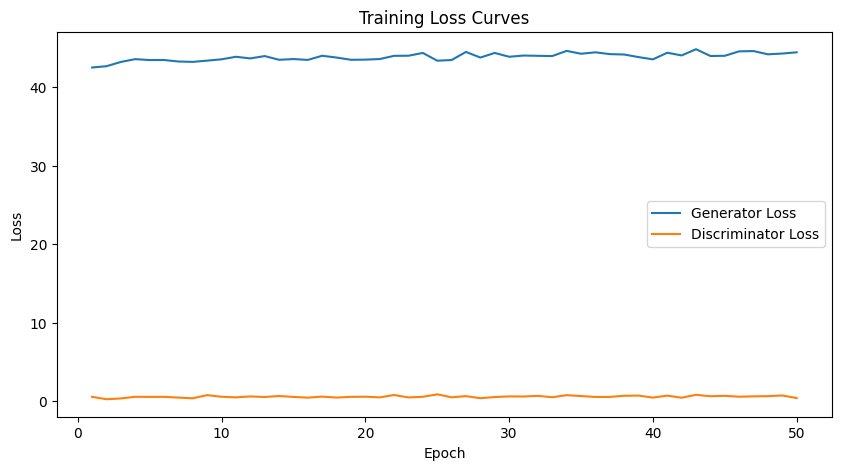

In [ ]:
#takes 2 hours

original_gen_losses = []
original_disc_losses = []

EPOCHS = 50

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    epoch_gen_loss = 0
    epoch_disc_loss = 0
    batches = 0
    for input_image, target in train_dataset:
        gen_loss, disc_loss = train_step(input_image, target)
        epoch_gen_loss += gen_loss.numpy()
        epoch_disc_loss += disc_loss.numpy()
        batches += 1

    avg_gen_loss = epoch_gen_loss / batches
    avg_disc_loss = epoch_disc_loss / batches
    original_gen_losses.append(avg_gen_loss)
    original_disc_losses.append(avg_disc_loss)
    print(f"Generator Loss: {avg_gen_loss:.4f}, Discriminator Loss: {avg_disc_loss:.4f}")


plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS+1), original_gen_losses, label='Generator Loss')
plt.plot(range(1, EPOCHS+1), original_disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Curves')
plt.show()

In [ ]:
## takes 300 minutes

learning_rates = [1e-4, 5e-5]
results = {}
EPOCHS = 50
for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    generator = Generator()  
    discriminator = Discriminator()  

    generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)
    
    epoch_gen_losses = []
    epoch_disc_losses = []
    
    for epoch in range(EPOCHS):
        total_gen_loss = 0.0
        total_disc_loss = 0.0
        batch_count = 0
        
        for input_image, target in train_dataset:

            gen_loss, disc_loss = train_step(input_image, target)
            total_gen_loss += gen_loss.numpy()
            total_disc_loss += disc_loss.numpy()
            batch_count += 1
        

        avg_gen_loss = total_gen_loss / batch_count
        avg_disc_loss = total_disc_loss / batch_count
        epoch_gen_losses.append(avg_gen_loss)
        epoch_disc_losses.append(avg_disc_loss)
        
        print(f"Epoch {epoch+1}/{EPOCHS}: Generator Loss = {avg_gen_loss:.4f}, Discriminator Loss = {avg_disc_loss:.4f}")
    
    results[lr] = {
        "gen_losses": epoch_gen_losses,
        "disc_losses": epoch_disc_losses
    }
    
    print(f"Final Generator Loss for lr {lr}: {epoch_gen_losses[-1]:.4f}")
    print(f"Final Discriminator Loss for lr {lr}: {epoch_disc_losses[-1]:.4f}")




Training with learning rate: 0.0001
Epoch 1/50: Generator Loss = 41.0132, Discriminator Loss = 1.5501
Epoch 2/50: Generator Loss = 39.8528, Discriminator Loss = 1.2824
Epoch 3/50: Generator Loss = 39.0028, Discriminator Loss = 1.1677
Epoch 4/50: Generator Loss = 38.2735, Discriminator Loss = 1.0487
Epoch 5/50: Generator Loss = 38.3516, Discriminator Loss = 0.9061
Epoch 6/50: Generator Loss = 38.3186, Discriminator Loss = 0.7973
Epoch 7/50: Generator Loss = 38.4424, Discriminator Loss = 0.6572
Epoch 8/50: Generator Loss = 38.9113, Discriminator Loss = 0.6471
Epoch 9/50: Generator Loss = 39.1720, Discriminator Loss = 0.5208
Epoch 10/50: Generator Loss = 39.4698, Discriminator Loss = 0.4286
Epoch 11/50: Generator Loss = 39.8550, Discriminator Loss = 0.3976
Epoch 12/50: Generator Loss = 40.1037, Discriminator Loss = 0.3086
Epoch 13/50: Generator Loss = 39.9542, Discriminator Loss = 0.5192
Epoch 14/50: Generator Loss = 40.2679, Discriminator Loss = 0.2976
Epoch 15/50: Generator Loss = 40.2

In [ ]:
print("Final Loss Comparison:")
print(f"Model (lr=1e-4): Final Generator Loss = {results[1e-4]['gen_losses'][-1]:.4f}, Final Discriminator Loss = {results[1e-4]['disc_losses'][-1]:.4f}")
print(f"Model (lr=5e-05): Final Generator Loss = {results[5e-05]['gen_losses'][-1]:.4f}, Final Discriminator Loss = {results[5e-05]['disc_losses'][-1]:.4f}")


Final Loss Comparison:
Model (lr=1e-4): Final Generator Loss = 43.2217, Final Discriminator Loss = 0.4379
Model (lr=5e-05): Final Generator Loss = 41.8946, Final Discriminator Loss = 0.3394


## Conclusion (15 pts)

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

The final loss values indicate that the model trained with a learning rate of 5e-05 achieved slightly lower losses for both the generator (41.8946 vs. 43.2217) and the discriminator (0.3394 vs. 0.4379) compared to the model trained with 1e-4. This suggests that a smaller learning rate allowed the networks to update more gently, resulting in a more stable training process and potentially better convergence.

Our experiments demonstrate that even relatively small changes in the learning rate can have a measurable impact on the training dynamics. A learning rate of 5e-05 performed better in our case, which emphasizes the importance of careful hyperparameter tuning.

In the future, in addition to learning rate, other hyperparameters such as batch size, optimizer beta parameters, or loss weightings (if using a combined loss function) could be tuned. We can also think about augmenting the training data may also help the network generalize better and improve the overall quality of generated images.